<a href="https://colab.research.google.com/github/Krystian3000/nft_price_prediciton/blob/main/tft_training_vol2_5min_aggregate_beanz_2hours_encoder_length.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb > /dev/null;
!pip install pytorch_forecasting > /dev/null;
!pip install pytorch_lightning==1.9.0 > /dev/null;

In [ ]:
import numpy as np
import pandas as pd
import wandb
from google.colab import userdata
from google.cloud import bigquery
import os
from pathlib import Path
import requests
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')

In [ ]:
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import MAE, RMSE, MAPE, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data.encoders import TorchNormalizer, GroupNormalizer
from pytorch_lightning.loggers import WandbLogger
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint

In [ ]:
import torch
import torch.nn as nn

# Load the data

In [ ]:
response = requests.get(f"https://raw.githubusercontent.com/Krystian3000/frontend/main/panelApps/nft-engineering-diploma-c933de618c2e.json?token=GHSAT0AAAAAACEDDV2HACZPSSQJIRAGWKXEZKKS3LQ", headers = {'Authorization': f'token {userdata.get("github_token")}'})

if response.status_code == 200:
    # If the request is successful, save the file locally
    with open("bigquery_secret.json", 'wb') as file:
        file.write(response.content)
    print("Successfully saved file")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")


Successfully saved file


In [ ]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.path.join(Path(os.getcwd()).resolve(), "bigquery_secret.json")

In [ ]:
wandb.login(key=userdata.get("wandb_api_key"))

wandb: Currently logged in as: krystian-opala. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb_logger = WandbLogger(
    log_model='all', #checkpoints logged during training
    project='tft_v2'
)

In [ ]:
def execute_query(query):
    # Create a BigQuery client
    client = bigquery.Client()

    # Create a context manager to ensure the connection is properly closed
    with client as bq_client:
        # Run the query
        query_job = bq_client.query(query)
        # Wait for the query to complete
        df = query_job.to_dataframe()

    client.close()
    del client

    return df

In [ ]:
query = f"""SELECT * EXCEPT(start_time), CAST (start_time as DATETIME) as date_time
           FROM `nft-engineering-diploma.beanz.5m_agg_beanz_collection`"""
df_raw = execute_query(query)

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169930 entries, 0 to 169929
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   contract_address       169285 non-null  object        
 1   cnt_active_listings    169285 non-null  Int64         
 2   active_floor_price     169285 non-null  object        
 3   active_max_price       169285 non-null  object        
 4   active_listed_volume   169285 non-null  object        
 5   cnt_new_auctions       169285 non-null  Int64         
 6   transaction_count      169285 non-null  Int64         
 7   avg_transaction_value  169285 non-null  float64       
 8   min_transaction_value  169285 non-null  float64       
 9   max_transaction_value  169285 non-null  float64       
 10  transaction_volume     169285 non-null  float64       
 11  date_time              169930 non-null  datetime64[ns]
dtypes: Int64(3), datetime64[ns](1), float64(4), 

In [ ]:
#Number of rows without NaN's --> go to dataset
len(df_raw.dropna())

169285

In [ ]:
df_raw.describe()

,cnt_active_listings,cnt_new_auctions,transaction_count,avg_transaction_value,min_transaction_value,max_transaction_value,transaction_volume
count,169285.0,169285.0,169285.0,169285.000000,169285.000000,169285.000000,169285.000000
mean,704.109496,1.176802,0.381741,0.077341,0.003956,0.319550,0.791238
std,480.991518,5.018589,2.212829,0.328275,0.118088,1.201521,6.115904
min,3.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,343.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
50%,626.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
75%,909.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000
max,3246.0,445.0,145.0,11.438943,7.200000,90.000000,519.065000


In [ ]:
df_raw.head()

,contract_address,cnt_active_listings,active_floor_price,active_max_price,active_listed_volume,cnt_new_auctions,transaction_count,avg_transaction_value,min_transaction_value,max_transaction_value,transaction_volume,date_time
0,None,<NA>,None,None,None,<NA>,<NA>,NaN,NaN,NaN,NaN,2022-03-29 00:00:00
1,None,<NA>,None,None,None,<NA>,<NA>,NaN,NaN,NaN,NaN,2022-03-29 00:05:00
2,None,<NA>,None,None,None,<NA>,<NA>,NaN,NaN,NaN,NaN,2022-03-29 00:10:00
3,None,<NA>,None,None,None,<NA>,<NA>,NaN,NaN,NaN,NaN,2022-03-29 00:15:00
4,None,<NA>,None,None,None,<NA>,<NA>,NaN,NaN,NaN,NaN,2022-03-29 00:20:00


Check if there are any datetime duplicates - multiple entries for 1 datetime value

In [ ]:
df_raw.loc[df_raw.date_time.duplicated(keep=False)].reset_index()

,index,contract_address,cnt_active_listings,active_floor_price,active_max_price,active_listed_volume,cnt_new_auctions,transaction_count,avg_transaction_value,min_transaction_value,max_transaction_value,transaction_volume,date_time
0,18433,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,2117,1.100000000,963.000000000,25425.125464510,0,0,0.000000,0.0,0.000,0.000,2022-06-01
1,18451,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,2117,1.100000000,963.000000000,25425.125464510,0,0,0.000000,0.0,0.000,0.000,2022-06-01
2,30698,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,876,0.780000000,169.690000000,3012.648890000,7,0,0.000000,0.0,0.000,0.000,2022-12-01
3,30762,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,876,0.780000000,169.690000000,3012.648890000,7,0,0.000000,0.0,0.000,0.000,2022-12-01
4,55671,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,389,1.369000000,120.000000000,2302.275298000,0,0,0.000000,0.0,0.000,0.000,2023-05-01
5,55743,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,389,1.369000000,120.000000000,2302.275298000,0,0,0.000000,0.0,0.000,0.000,2023-05-01
6,60939,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,431,1.474600000,150.000000000,2676.743401920,0,0,0.000000,0.0,0.000,0.000,2023-03-01
7,60941,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,431,1.474600000,150.000000000,2676.743401920,0,0,0.000000,0.0,0.000,0.000,2023-03-01
8,70120,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,766,0.895100000,420.690000000,3760.058896697,0,0,0.000000,0.0,0.000,0.000,2023-01-01
9,70146,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,766,0.895100000,420.690000000,3760.058896697,0,0,0.000000,0.0,0.000,0.000,2023-01-01


Duplicates exactly the same - can remove safely

In [ ]:
df_raw = df_raw.drop_duplicates(subset=['date_time']).reset_index(drop=True)

Date time range

In [ ]:
df_raw['date_time'].agg(['min','max'])['min']

Timestamp('2022-03-29 00:00:00')

In [ ]:
df_raw['date_time'].agg(['min','max'])['max']

Timestamp('2023-11-09 00:00:00')

## Missing values in datetime column

Missing values in this context mean that no new listing has been created in given 5 minutes interval. To cope with this problem we'll substitute missing values with previous values

In [ ]:
dt_left = pd.DataFrame(pd.date_range(*df_raw.dropna().date_time.agg(["min","max"]), freq='5min', inclusive='both'), columns=['date_time'])
dt_left.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169276 entries, 0 to 169275
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date_time  169276 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.3 MB


In [ ]:
dt_left['date_time'].agg(['min','max'])['min']

Timestamp('2022-03-31 05:45:00')

In [ ]:
dt_left['date_time'].agg(['min','max'])['max']

Timestamp('2023-11-09 00:00:00')

In [ ]:
df_raw_ffill = dt_left.merge(df_raw.dropna(), on='date_time',how='left').sort_values('date_time').dropna().fillna('ffill').reset_index(drop=True) #replace missing values with previous

In [ ]:
df_raw_ffill

,date_time,contract_address,cnt_active_listings,active_floor_price,active_max_price,active_listed_volume,cnt_new_auctions,transaction_count,avg_transaction_value,min_transaction_value,max_transaction_value,transaction_volume
0,2022-03-31 05:45:00,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,3,5.000000000,6.969000000,18.869000000,3,0,0.000,0.0,0.0,0.0
1,2022-03-31 05:50:00,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,3,5.000000000,6.969000000,18.869000000,1,0,0.000,0.0,0.0,0.0
2,2022-03-31 05:55:00,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,5,4.999999000,6.969000000,39.868999000,4,0,0.000,0.0,0.0,0.0
3,2022-03-31 06:00:00,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,9,3.900000000,6.969000000,55.393999000,10,0,0.000,0.0,0.0,0.0
4,2022-03-31 06:05:00,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,15,2.990000000,6.990000000,76.509000000,17,2,0.525,0.0,3.2,6.3
...,...,...,...,...,...,...,...,...,...,...,...,...
169271,2023-11-08 23:40:00,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,31,0.430000000,2.731900000,21.512088000,0,0,0.000,0.0,0.0,0.0
169272,2023-11-08 23:45:00,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,31,0.430000000,2.731900000,21.512088000,0,0,0.000,0.0,0.0,0.0
169273,2023-11-08 23:50:00,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,31,0.430000000,2.731900000,21.512088000,0,0,0.000,0.0,0.0,0.0
169274,2023-11-08 23:55:00,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,31,0.430000000,2.731900000,21.512088000,0,0,0.000,0.0,0.0,0.0


In [ ]:
df = df_raw_ffill.rename(columns={'active_floor_price':'price'}).astype({"price":np.float16}).set_index('date_time').copy() #deepcopy to avoid inference
df

,contract_address,cnt_active_listings,price,active_max_price,active_listed_volume,cnt_new_auctions,transaction_count,avg_transaction_value,min_transaction_value,max_transaction_value,transaction_volume
date_time,,,,,,,,,,,
2022-03-31 05:45:00,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,3,5.000000,6.969000000,18.869000000,3,0,0.000,0.0,0.0,0.0
2022-03-31 05:50:00,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,3,5.000000,6.969000000,18.869000000,1,0,0.000,0.0,0.0,0.0
2022-03-31 05:55:00,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,5,5.000000,6.969000000,39.868999000,4,0,0.000,0.0,0.0,0.0
2022-03-31 06:00:00,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,9,3.900391,6.969000000,55.393999000,10,0,0.000,0.0,0.0,0.0
2022-03-31 06:05:00,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,15,2.990234,6.990000000,76.509000000,17,2,0.525,0.0,3.2,6.3
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-08 23:40:00,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,31,0.429932,2.731900000,21.512088000,0,0,0.000,0.0,0.0,0.0
2023-11-08 23:45:00,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,31,0.429932,2.731900000,21.512088000,0,0,0.000,0.0,0.0,0.0
2023-11-08 23:50:00,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,31,0.429932,2.731900000,21.512088000,0,0,0.000,0.0,0.0,0.0


Number of rows is correct with number of Non-null rows (every column apart from datetime) in original dataframe

### Additional verification

In [ ]:
# Calculate time differences in seconds
tmp = df_raw_ffill.copy()
tmp['time_difference'] = tmp['date_time'].diff().dt.total_seconds()

# Add a status column based on the time difference
tmp['status'] = tmp['time_difference'].apply(lambda x: 'Exactly 5 minutes' if x == 300 else 'Not 5 minutes')


In [ ]:
tmp['status'].value_counts()

Exactly 5 minutes    169275
Not 5 minutes             1
Name: status, dtype: int64

In [ ]:
tmp.loc[tmp.status=='Not 5 minutes']

,date_time,contract_address,cnt_active_listings,active_floor_price,active_max_price,active_listed_volume,cnt_new_auctions,transaction_count,avg_transaction_value,min_transaction_value,max_transaction_value,transaction_volume,time_difference,status
0,2022-03-31 05:45:00,0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949,3,5.000000000,6.969000000,18.869000000,3,0,0.0,0.0,0.0,0.0,NaN,Not 5 minutes


Only 0 row - correct as there is nothing to be compared to (any previous row)

## Load static files

In [ ]:
from google.cloud import storage

def download_objects(bucket_name, local_directory):
    """Download all objects from a Google Cloud Storage bucket to a local directory."""
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blobs = bucket.list_blobs()

    for blob in blobs:
        destination_file_path = f"{local_directory}/{blob.name}"
        blob.download_to_filename(destination_file_path)
        print(f"Downloaded: {blob.name} to {destination_file_path}")

In [ ]:
download_objects('predictive_model_static', os.getcwd())

Downloaded: nft_worldwide_google_search.csv to /content/nft_worldwide_google_search.csv
Downloaded: s&p500-2018-2023.11.10.xls to /content/s&p500-2018-2023.11.10.xls


## Create additional datetime features + load static files

In [ ]:
def create_ts_features(df):
  df['datetime'] = df.index
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  df['Date'] = pd.to_datetime(df.index.date) #tmp

  #nft searches weekly - interest level
  df_nft_worldwide = (pd.read_csv("nft_worldwide_google_search.csv", skiprows=3, parse_dates=[0], infer_datetime_format='%Y-%m', names=['Year_month','google_searches_nft_scaled'])
                      .replace({"google_searches_nft_scaled":{"<1":"0"}})
                      .reset_index(drop=True)
                      .astype({'google_searches_nft_scaled':int})
                      .assign(google_searches_nft_scaled = lambda x:x['google_searches_nft_scaled'] / 100))
  # Expand the rows
  expanded_df = pd.DataFrame({
    'Date': df_nft_worldwide.apply(lambda row: pd.date_range(row['Year_month'], row['Year_month'] + pd.DateOffset(months=1, days=-1), freq='D'), axis=1).explode(),
    'google_searches_nft_scaled': df_nft_worldwide['google_searches_nft_scaled'].repeat(df_nft_worldwide['Year_month'].dt.days_in_month)
  }).reset_index(drop=True)

  df = df.merge(expanded_df, on='Date', how='left')

  #s&p500 - external market indice; quick look at the stock market and economy status
  df_sp500 = (pd.read_excel("s&p500-2018-2023.11.10.xls", skiprows=7, names=['datetime','sp500_value'], parse_dates=['datetime'])
              .dropna()
              .assign(datetime=lambda x: pd.to_datetime(x['datetime']))
              )

  expanded_df_sp500 = df_sp500.set_index('datetime').resample('1min').ffill()

  df = df.merge(expanded_df_sp500, on='datetime', how='left')
  df = df.drop(columns=['Date'])
  df = df.rename(columns={'datetime':'date_time'})
  df = df.set_index('date_time')
  return df

In [ ]:
df_features = create_ts_features(df)

In [ ]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 169276 entries, 2022-03-31 05:45:00 to 2023-11-09 00:00:00
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   contract_address            169276 non-null  object 
 1   cnt_active_listings         169276 non-null  Int64  
 2   price                       169276 non-null  float16
 3   active_max_price            169276 non-null  object 
 4   active_listed_volume        169276 non-null  object 
 5   cnt_new_auctions            169276 non-null  Int64  
 6   transaction_count           169276 non-null  Int64  
 7   avg_transaction_value       169276 non-null  float64
 8   min_transaction_value       169276 non-null  float64
 9   max_transaction_value       169276 non-null  float64
 10  transaction_volume          169276 non-null  float64
 11  hour                        169276 non-null  int64  
 12  dayofweek                   169276 non

### Additionally adding time_idx

In [ ]:
import gc
# add time index
tmp = df_features.reset_index().drop_duplicates()
data = (tmp.merge((tmp[['date_time']].drop_duplicates(ignore_index=True)
.rename_axis('time_idx')).reset_index(), on = ['date_time'])).set_index('date_time').copy()
data = data.astype({'time_idx':np.int32})
del tmp
gc.collect()

17362

### Correct data types

In [ ]:
#Only 1 group
data['group'] = 'beanz'

for col in ['hour','dayofweek','quarter','month','year','dayofyear']:
  data[col] = data[col].astype(str).astype('category')

data = data.drop(columns=['contract_address'])

data=data.astype({
    "cnt_active_listings":    np.int16,
    "price":                  np.float16,
    "active_max_price":       np.float16,
    "active_listed_volume":   np.int32,
    "cnt_new_auctions":       np.int16,
    "transaction_count":      np.int16,
    "avg_transaction_value":  np.float32,
    "min_transaction_value":  np.float32,
    "max_transaction_value":  np.float32,
    "transaction_volume":     np.float16,
    "google_searches_nft_scaled": np.float16,
    "sp500_value":            np.float16
})

# Dataset ready --> small eda

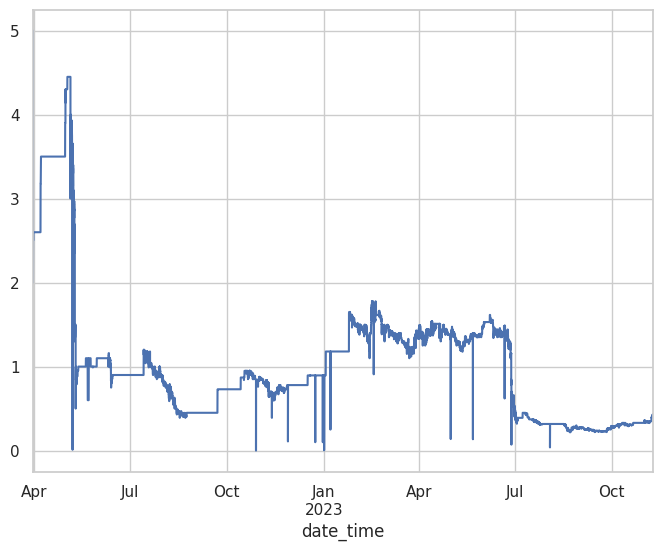

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
data['price'].plot(ax=ax)
plt.show()

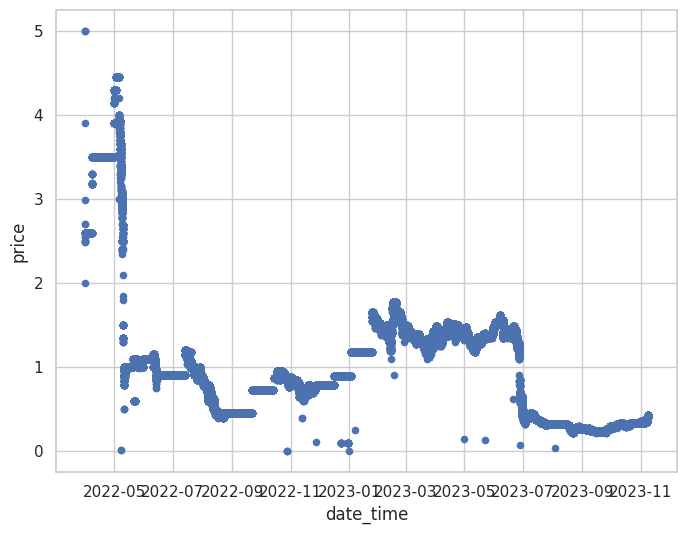

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
data.reset_index().plot(x='date_time', y='price', kind='scatter', ax=ax)
plt.show()

Some outliers are preset in the dataset (extreme changes in price data - price drops to nearly 0)

Goal: replace outliers with past aggregate value

# Outlier detection

Firstly we'll try to detect outliers using Isolation forest

Simpler algorithm in contrast to LSTM for anomaly detection may be sufficient for imporoving TFT model score

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
#Prep data for outlier detection
tmp = data.copy()
tmp = tmp.drop(columns=['group'])

# Encode categorical variables
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False, drop='first')

categorical_columns = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
for col in categorical_columns:
    encoded_cols = pd.get_dummies(tmp[col], prefix=col, drop_first=True)
    tmp = pd.concat([tmp, encoded_cols], axis=1)


# Drop the original categorical columns
tmp = tmp.drop(columns=categorical_columns)

# Standardize numerical variables
numerical_columns = tmp.select_dtypes(include=['float16', 'int16']).columns
scaler = StandardScaler()
tmp[numerical_columns] = scaler.fit_transform(tmp[numerical_columns])

In [ ]:
tmp

,cnt_active_listings,price,active_max_price,active_listed_volume,cnt_new_auctions,transaction_count,avg_transaction_value,min_transaction_value,max_transaction_value,transaction_volume,...,dayofyear_90,dayofyear_91,dayofyear_92,dayofyear_93,dayofyear_94,dayofyear_95,dayofyear_96,dayofyear_97,dayofyear_98,dayofyear_99
date_time,,,,,,,,,,,,,,,,,,,,,
2022-03-31 05:45:00,-1.457633,5.077368,-0.942569,18,0.363281,-0.172513,0.000,0.0,0.0,-0.129376,...,1,0,0,0,0,0,0,0,0,0
2022-03-31 05:50:00,-1.457633,5.077368,-0.942569,18,-0.035230,-0.172513,0.000,0.0,0.0,-0.129376,...,1,0,0,0,0,0,0,0,0,0
2022-03-31 05:55:00,-1.453475,5.077368,-0.942569,39,0.562537,-0.172513,0.000,0.0,0.0,-0.129376,...,1,0,0,0,0,0,0,0,0,0
2022-03-31 06:00:00,-1.445159,3.666551,-0.942569,55,1.758070,-0.172513,0.000,0.0,0.0,-0.129376,...,1,0,0,0,0,0,0,0,0,0
2022-03-31 06:05:00,-1.432685,2.498804,-0.942508,76,3.152858,0.731288,0.525,0.0,3.2,0.900824,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-08 23:40:00,-1.399420,-0.786108,-0.955793,21,-0.234485,-0.172513,0.000,0.0,0.0,-0.129376,...,0,0,0,0,0,0,0,0,0,0
2023-11-08 23:45:00,-1.399420,-0.786108,-0.955793,21,-0.234485,-0.172513,0.000,0.0,0.0,-0.129376,...,0,0,0,0,0,0,0,0,0,0
2023-11-08 23:50:00,-1.399420,-0.786108,-0.955793,21,-0.234485,-0.172513,0.000,0.0,0.0,-0.129376,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
IF = IsolationForest(random_state=42)
IF.fit(tmp)

IsolationForest(random_state=42)

In [ ]:
tmp['anomaly_score'] = IF.decision_function(tmp)

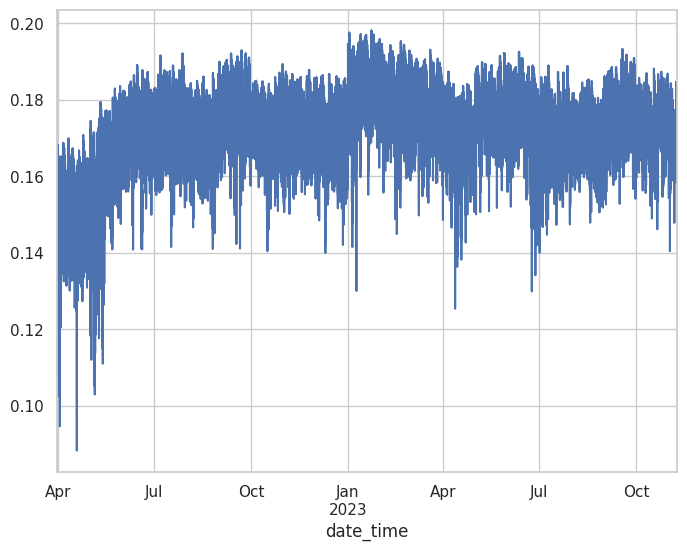

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
tmp['anomaly_score'].plot(ax=ax)
plt.show()

In [ ]:
tmp['prediction'] = pd.Series(IF.predict(tmp.drop(columns=['anomaly_score'])))

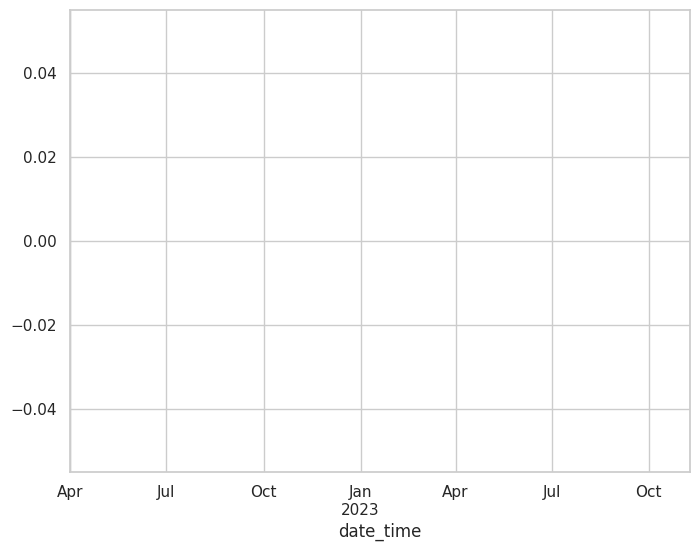

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
tmp['prediction'].plot(ax=ax)
plt.show()

Isolation forest hasn't identified any outliers (no outlier score value is lower than 0)

### LSTM Autoencoder for outlier detection

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

class RecurrentAutoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [ ]:
del tmp
gc.collect()

4528

#Encoder length

# Creating pytorch's TimeSeriesDataset

We are trying to predict next 30 minutes (6 5-minute time steps ahead)

Encoder length - one experiment with 5 - 25 minutes before - Autoarima best model ARIMA(5,1,1)
  - autoregressive part = 5 meaning at least 5 lags influence significantly

For this experiment we'll start with more complex model - length of encoder = 24 (2 hours from the past as an input)
  - tradeoff - more complex model --> less interpretabel

In the future experiments we'll try to reduce length of encoder

In [ ]:
max_prediction_length = 6 #predicting 30 minutes ahead
max_encoder_length = 24 #predicting using past 2 hours --> sufficient time range for catching temporal changes in prices
training_cutoff = data["time_idx"].max() - max_prediction_length #last 30 minutes for validation

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 169276 entries, 2022-03-31 05:45:00 to 2023-11-09 00:00:00
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   cnt_active_listings         169276 non-null  int16   
 1   price                       169276 non-null  float16 
 2   active_max_price            169276 non-null  float16 
 3   active_listed_volume        169276 non-null  int32   
 4   cnt_new_auctions            169276 non-null  int16   
 5   transaction_count           169276 non-null  int16   
 6   avg_transaction_value       169276 non-null  float32 
 7   min_transaction_value       169276 non-null  float32 
 8   max_transaction_value       169276 non-null  float32 
 9   transaction_volume          169276 non-null  float16 
 10  hour                        169276 non-null  category
 11  dayofweek                   169276 non-null  category
 12  quarter                 

In [ ]:
data.describe()

,cnt_active_listings,price,active_max_price,active_listed_volume,cnt_new_auctions,transaction_count,avg_transaction_value,min_transaction_value,max_transaction_value,transaction_volume,google_searches_nft_scaled,sp500_value,time_idx
count,169276.000000,169276.000000,169276.000,169276.000000,169276.000000,169276.000000,169276.000000,169276.000000,169276.000000,169276.0,169276.000000,169276.0,169276.000000
mean,704.103565,NaN,NaN,4804.586433,1.176806,0.381749,0.077344,0.003957,0.319564,NaN,0.000000,NaN,84637.500000
std,480.988990,0.000000,NaN,6555.507287,5.018697,2.212882,0.328283,0.118091,1.201551,NaN,0.000000,NaN,48865.916421
min,3.000000,0.000100,2.000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.049988,3578.0,0.000000
25%,343.000000,0.449951,88.875,1596.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.080017,3932.0,42318.750000
50%,626.000000,0.899902,169.750,3393.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.109985,4108.0,84637.500000
75%,909.000000,1.370117,420.750,4735.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.160034,4308.0,126956.250000
max,3246.000000,5.000000,1992.000,54264.000000,445.000000,145.000000,11.438943,7.200000,90.000000,519.0,0.449951,4588.0,169275.000000


In [ ]:
data_=data.reset_index().copy()

In [ ]:
np.any(np.isnan(data_.drop(columns=['hour','dayofweek','quarter','month','year','dayofyear','group'])))

False

In [ ]:
np.all(np.isfinite(data_.drop(columns=['hour','dayofweek','quarter','month','year','dayofyear','group'])))

True

In [ ]:
data_.isna().any()

date_time                     False
cnt_active_listings           False
price                         False
active_max_price              False
active_listed_volume          False
cnt_new_auctions              False
transaction_count             False
avg_transaction_value         False
min_transaction_value         False
max_transaction_value         False
transaction_volume            False
hour                          False
dayofweek                     False
quarter                       False
month                         False
year                          False
dayofyear                     False
google_searches_nft_scaled    False
sp500_value                   False
time_idx                      False
group                         False
dtype: bool

In [ ]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx='time_idx',
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals = ['hour','dayofweek','quarter','month','year','dayofyear'],
    time_varying_known_reals = ['time_idx'],
    time_varying_unknown_reals  = ['cnt_active_listings','price','active_max_price','active_listed_volume',
                                   'cnt_new_auctions','transaction_count','avg_transaction_value','min_transaction_value','max_transaction_value', 'transaction_volume',
                                   'google_searches_nft_scaled', 'sp500_value'],
    allow_missing_timesteps = False,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    target_normalizer = GroupNormalizer(
        groups=["group"], transformation="softplus"
    ),
    target='price',
    group_ids=['group'],
    static_categoricals=['group']
)

validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

In [ ]:
os.cpu_count()

8

In [ ]:
torch.set_float32_matmul_precision("high") #losing some precision in favour of perfomance

In [ ]:
# create dataloaders for model
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=2)

# Training

In [ ]:
checkpoint_callback = ModelCheckpoint(monitor="val_loss")
lr_logger = LearningRateMonitor()  # log the learning rate
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min") #stop when training no longer effective

In [ ]:
pl.seed_everything(42)
trainer = pl.Trainer(
    max_epochs=10,
    enable_model_summary=True,
    accelerator="gpu", devices=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, lr_logger, early_stop_callback]
)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    lstm_layers=2,
    hidden_size=8,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    optimizer="Ranger",
    #reduce_on_plateau_patience=10,  # reduce learning rate if no improvement in validation loss after x epochs
)
wandb_logger.watch(tft)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:43: attribute 'loss' removed from hparams because it cannot be pickled
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:43: attribute 'logging_metrics' removed from hparams because it cannot be pickled
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO: LR finder stopped early after 916 steps due to diverging loss.
INFO:lightning.pytorch.tuner.lr_finder:LR finder stopped early after 916 steps due to diverging loss.
INFO: Learning rate set to 0.001109174815262401
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.001109174815262401
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_9285f55d-a037-4e84-8a6c-9325c5f0d7f8.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_9285f55d-a037-4e84-8a6c-9325c5f0d7f8.ckpt


suggested learning rate: 0.001109174815262401


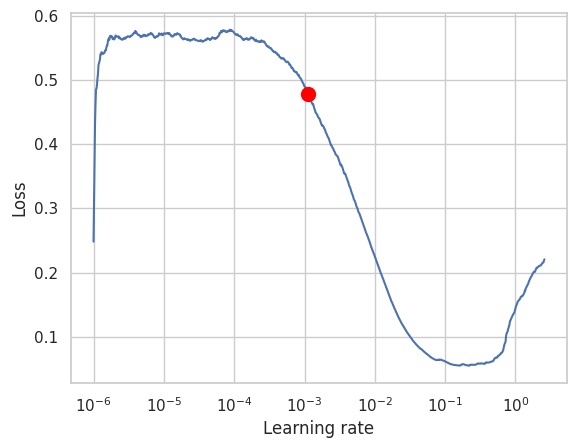

In [ ]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
    num_training=1000
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
# Pick point based on plot, or get suggestion
new_lr = res.suggestion()

# update hparams of the model
tft.hparams.lr = new_lr

### Beginning training

In [ ]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 3.2 K 
3  | prescalers                         | ModuleDict                      | 272   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.2 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.4 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initia

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


# Evaluating performance

In [ ]:
import wandb
run = wandb.init()
artifact = run.use_artifact('krystian-opala/tft_v2/model-h6jwkk6q:v6', type='model')
artifact_dir = artifact.download()

wandb:   1 of 1 files downloaded.  


In [ ]:
artifact_dir

'/content/artifacts/model-h6jwkk6q:v6'

In [ ]:
# Load the checkpoint and inspect its content
checkpoint = torch.load(os.path.join(artifact_dir, "model.ckpt"))

# Remove the 'lr' key from the state_dict
keys_to_remove = ['lr', 'epoch']
for key in keys_to_remove:
    if key in checkpoint['hyper_parameters']:
        del checkpoint['hyper_parameters'][key]

In [ ]:
best_tft = TemporalFusionTransformer(**checkpoint['hyper_parameters'])
best_tft.load_state_dict(checkpoint['state_dict'])

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


<All keys matched successfully>

In [ ]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAPE()(predictions.output, predictions.y)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


tensor(0.0374)

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


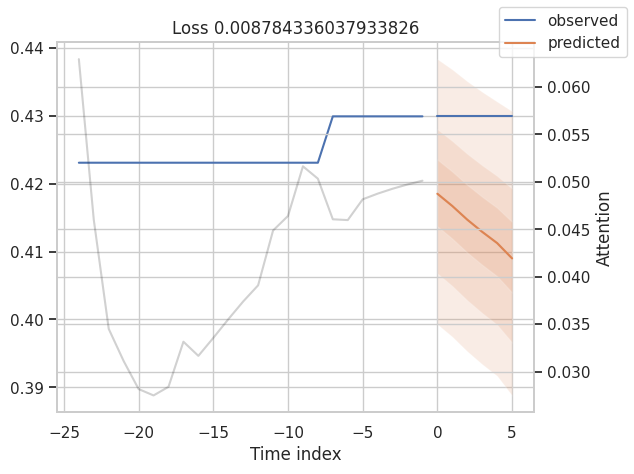

In [ ]:
best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True)
plt.show()

Model has made a slight mistake by predicting that the price will fall, but the true result is within 95% confidence interval

In [ ]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


# Variable importance

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x700 with 1 Axes>,
 'decoder_variables': <Figure size 700x400 with 1 Axes>}

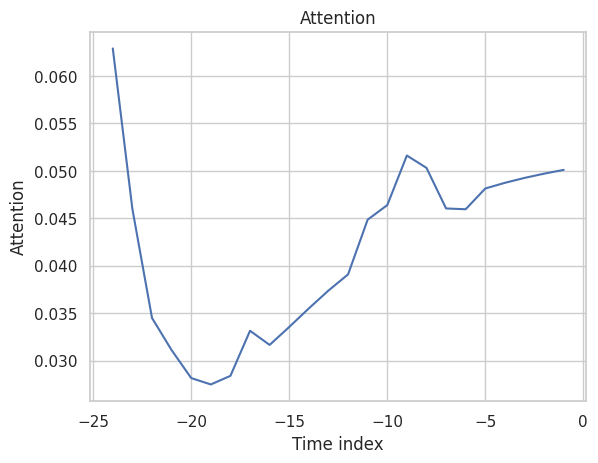

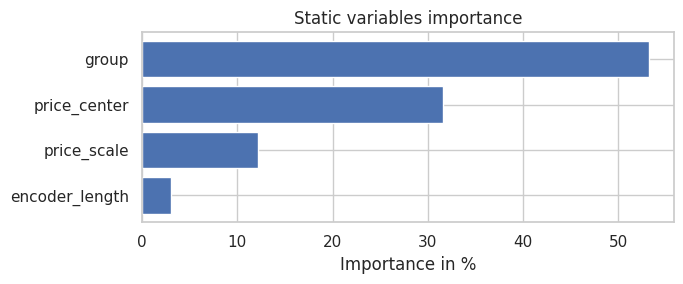

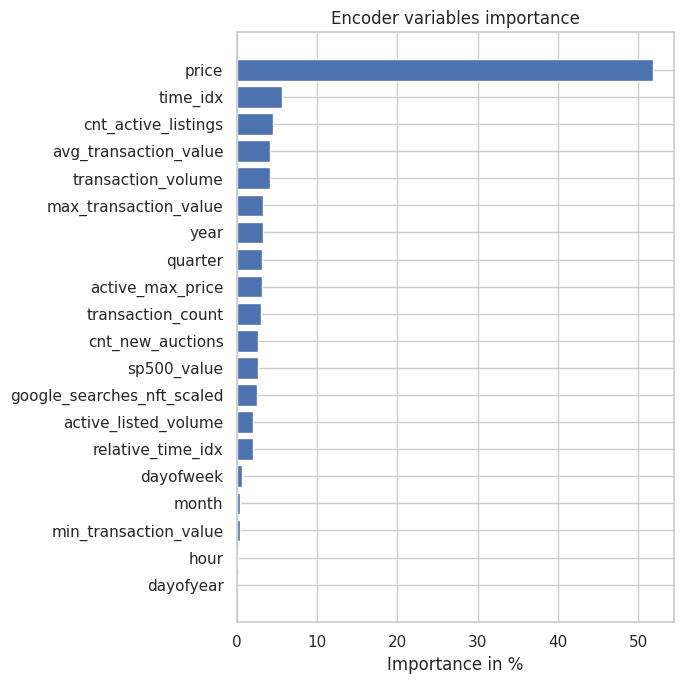

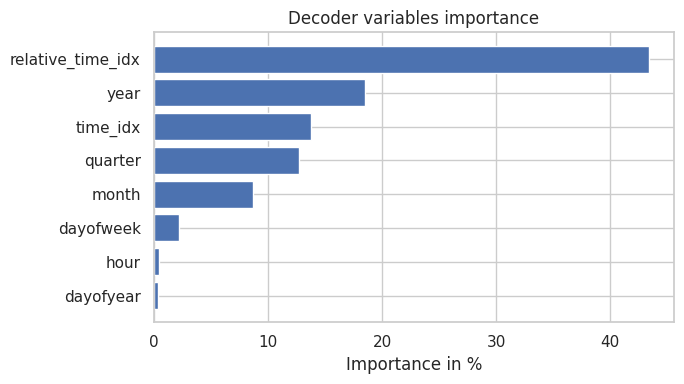

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

### Predicting new data